# 태양광 발전량 예측 대회_데이콘

# 1. Business Understanding

이 대회는 조금 특이합니다. 자세한 건 아래를 참고하세요.<br>
https://medium.com/analytics-vidhya/a-tutorial-on-quantile-regression-quantile-random-forests-and-quantile-gbm-d3c651af7516

핵심은 이 대회는 OLS가 아닌 QR이라고 해서 Quantile Regression을 사용하는 대회입니다. quantile 은 0.1 ~ 0.9 까지 0.1 단위로 9개의 구간입니다.

Loss Function은 Pinball Loss라고 해서 왜 핀볼인지는 모르겠지만 대회를 참고하세요. 아무튼 중요한 것은 분위수가 높으면서 값이 벌어질수록 페널티가 커지고, 분위수가 낮을수록 값이 벌어지면 또 페널티가 커지는. 그냥 정답 값에서 분위수와 동시에 멀어지면 멀어질수록 페널티가 늘어가는 것입니다. 즉 9개의 모델들이 최대한 가운데 뭉쳐서 예측하는 것이 중요합니다.

그리고 또 하나 특이한 점은, train셋은 3년치 데이터가 주어집니다. 그러나 test셋은 7일 단위로 81개가 주어집니다. 총 2년치 데이텁니다. 그러나 시간순이 아니라 랜덤입니다. 다만 중요한 건 다음 2일 간의 예측을 하는 것입니다.

pre-trained 모델 금지, 외부데이터 금지

public score는 제출 답의 50% 로 산정, private score는 100%로 산정

7주일치의 기상 데이터를 집어 넣었을 때, 다음 이틀 간의 태양광 발전량을 내뱉어야 합니다.<br>
즉 이것은 어떻게 보면 기상 예측 대회일 수도 있습니다.<br>
또 어찌 보면 피쳐를 시프트해서 예측해야 하는 문제일 수도 있습니다.<br>
여기에 시계열 분석을 더해줄 수도 있습니다.<br>
LSTM이나 Wave-Net을 통한 예측 모델일 수도 있습니다.

- Hour - 시간
- Minute - 분
- DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2)) : 확산일사라고도 하며, 대기 중의 수증기나 부유 입자의 산란으로 인해 지표면에 도달하게 되는 태양 복사 에너지의 양.
- DNI - 직달일사량(Direct Normal Irradiance (W/m2)) : 태양에서 출발한 광선이 대기중의 수증기나 먼지등에 흡수나 산란되지 않고 지표면에 도달하는 것을 직달일사라고 하는데, 직달일사량은 지표의 단위면적이 단위시간에 받는 일사열량을 나타내는 것. 일반적으로 60~70%가 직달일사량. 그 반대로 확산일사가 있음
- WS - 풍속(Wind Speed (m/s))
- RH - 상대습도(Relative Humidity (%))
- T - 기온(Temperature (Degree C))
- Target - 태양광 발전량 (kW)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sktime
from tqdm import tqdm
import time

In [2]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(sklearn.__version__)
print(sktime.__version__)

1.0.5
1.19.3
0.10.1
0.23.1
0.4.3


In [3]:
import tensorflow as tf

In [4]:
print(tf.__version__)

2.3.1


sktime이라는 TS전용 라이브러리입니다. sklearn의 사촌동생입니다.<br>
https://github.com/alan-turing-institute/sktime

In [5]:
# load_dtypes()
# DF 불러올 때부터 축소해서 가져오는 함수.

def load_dtypes(file_path):
    print(file_path)
    tmp = pd.read_csv(file_path, nrows=0) # 애초에 파일을 불러올 때
    col_dtypes= {}
    for col in tmp.columns:
        df = pd.read_csv(file_path, usecols=[col]) # 애초에 파일을 불러올 때
        
        dtype = df[col].dtype
        
        if (dtype == 'int8' or dtype == 'int16' or dtype == 'int32' or dtype == 'int64'):
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'int'
            
        elif dtype == 'float32' or dtype == 'float64':
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'float'
            
        elif dtype == 'object':
            n_unique = df[col].nunique()
            threshold = n_unique / df.shape[0]
            
        if dtype == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col_dtype = 'int8'
            elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                col_dtype = 'uint8'
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col_dtype = 'int16'
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                col_dtype = 'uint16'
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col_dtype = 'int32'
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                col_dtype = 'uint32'
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col_dtype = 'int64'
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                col_dtype = 'uint64'
                
        elif dtype == 'float':
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col_dtype = 'float32'
            else:
                col_dtype = 'float64'
                
        elif dtype == 'object':
            if threshold > 0.7:
                col_dtype = 'object'
            else:
                col_dtype = 'category'
                
        col_dtypes[col] = col_dtype
        

    df = pd.read_csv(file_path, dtype=col_dtypes)
    
    return df

In [6]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [7]:
train = load_dtypes(TRAIN_PATH)
train.info()

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [8]:
#train = pd.read_csv(TRAIN_PATH)
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.080002,-12,0.0
1,0,0,30,0,0,1.5,69.059998,-12,0.0
2,0,1,0,0,0,1.6,71.779999,-12,0.0
3,0,1,30,0,0,1.6,71.750000,-12,0.0
4,0,2,0,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.699997,-4,0.0
52556,1094,22,0,0,0,2.4,66.790001,-4,0.0
52557,1094,22,30,0,0,2.2,66.779999,-4,0.0
52558,1094,23,0,0,0,2.1,67.720001,-4,0.0


In [109]:
# test set load

df_test = []

for i in range(81):
    file_path = TEST_PATH + '/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    #temp = preprocess_data(temp, target_lags=[48], weather_lags=[48], is_train=False).iloc[-48:]
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(27216, 9)

In [334]:
X_test.rename({'T':'TEMP'}, axis=1, inplace=True)

In [207]:
# 0~80 까지의 test 데이터에 대한 7일~8일의 quantile 예측량입니다.
submission = pd.read_csv(SUBMISSION_PATH)

In [11]:
# check_dtypes()
# 이미 불러온 DF의 Dtype을 최적화해줍니다.
def check_dtypes(df):
    col_dtypes= {}
    for col in df.columns:
        dtype = df[col].dtype
        
        if (dtype == 'int8' or dtype == 'int16' or dtype == 'int32' or dtype == 'int64'):
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'int'
            
        elif dtype == 'float32' or dtype == 'float64':
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'float'
            
        elif dtype == 'object':
            n_unique = df[col].nunique()
            threshold = n_unique / df.shape[0]
            
        if dtype == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col_dtype = 'int8'
            elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                col_dtype = 'uint8'
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col_dtype = 'int16'
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                col_dtype = 'uint16'
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col_dtype = 'int32'
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                col_dtype = 'uint32'
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col_dtype = 'int64'
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                col_dtype = 'uint64'
                
        elif dtype == 'float':
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col_dtype = 'float32'
            else:
                col_dtype = 'float64'
                
        elif dtype == 'object':
            if threshold > 0.7:
                col_dtype = 'object'
            else:
                col_dtype = 'category'
                
        col_dtypes[col] = col_dtype
    
    df = df.astype(col_dtypes)
    
    return df

In [12]:
#check_dtypes(train).info()

# 2. Data Understanding

In [182]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


In [12]:
train.describe()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939


In [175]:
train.isnull().sum()

Day       0
Hour      0
Minute    0
DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

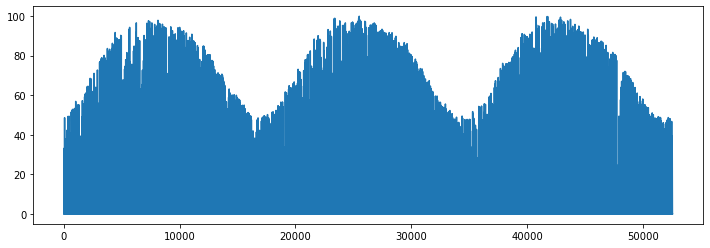

In [15]:
# 먼저 타겟값의 트렌드를 살펴봅시다.
train.TARGET.plot(figsize=(12, 4))
plt.show()

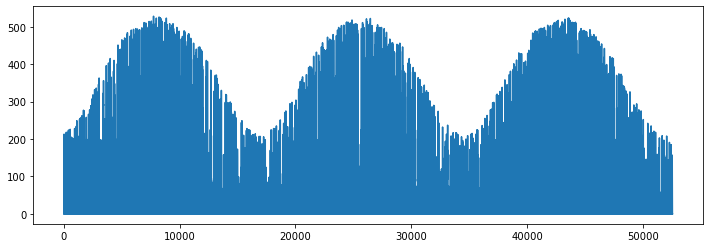

In [16]:
# DHI의 트렌드를 살펴봅시다.
train.DHI.plot(figsize=(12, 4))
plt.show()

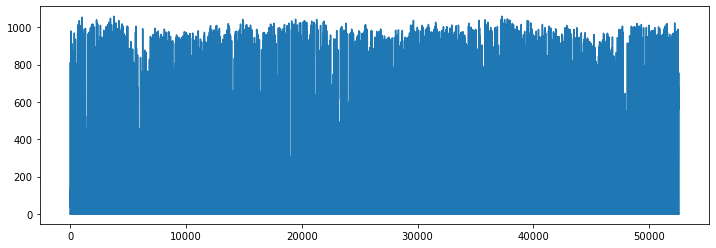

In [17]:
# DNI의 트렌드를 살펴봅시다.
train.DNI.plot(figsize=(12, 4))
plt.show()

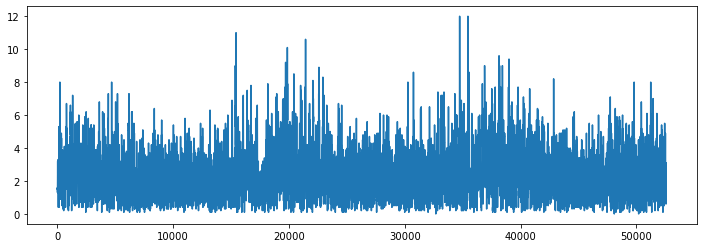

In [18]:
# WS의 트렌드를 살펴봅시다.
train.WS.plot(figsize=(12, 4))
plt.show()

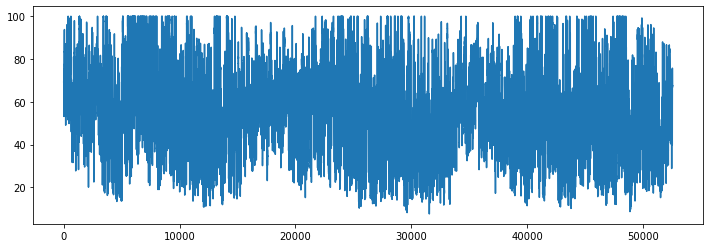

In [19]:
# RH의 트렌드를 살펴봅시다.
train.RH.plot(figsize=(12, 4))
plt.show()

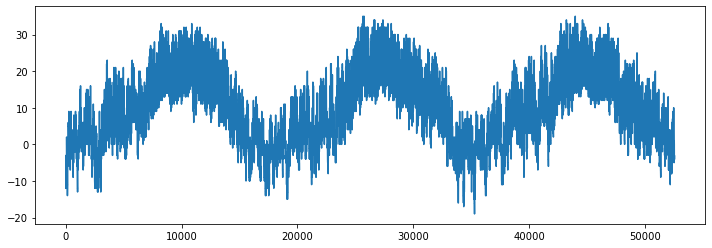

In [21]:
# T의 트렌드를 살펴봅시다.
train['T'].plot(figsize=(12, 4))
plt.show()

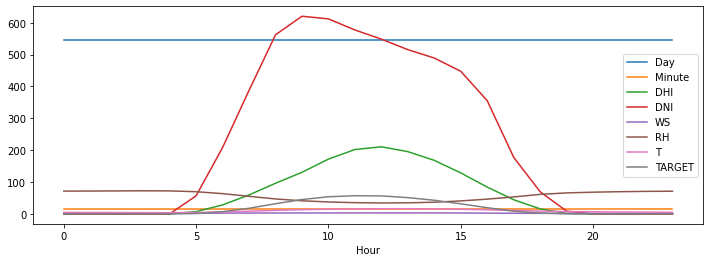

In [25]:
# 시간대별로 살펴봐봅니다.
train.groupby(['Hour']).mean().plot(figsize=(12, 4))
plt.show()

In [105]:
train_shift = train.copy()

In [106]:
train_shift[['DHI', 'DNI', 'WS', 'RH', 'T']] = train_shift[['DHI', 'DNI', 'WS', 'RH', 'T']].shift(periods=96, freq=None, axis=0)
train_shift = train_shift.iloc[96:,]
train_shift

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
96,2,0,0,0.0,0.0,1.5,69.08,-12.0,0.0
97,2,0,30,0.0,0.0,1.5,69.06,-12.0,0.0
98,2,1,0,0.0,0.0,1.6,71.78,-12.0,0.0
99,2,1,30,0.0,0.0,1.6,71.75,-12.0,0.0
100,2,2,0,0.0,0.0,1.6,75.20,-12.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0.0,0.0,3.5,55.97,-1.0,0.0
52556,1094,22,0,0.0,0.0,3.9,54.23,-2.0,0.0
52557,1094,22,30,0.0,0.0,4.1,54.21,-2.0,0.0
52558,1094,23,0,0.0,0.0,4.3,56.46,-2.0,0.0


# 4. Modeling

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
# 타겟값을 미리 만들어줘야 합니다.
train['TARGET_1'] = train.TARGET.shift(48)
train['TARGET_2'] = train.TARGET_1.shift(48)
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_1,TARGET_2
0,0,0,0,0,0,1.5,69.080002,-12,0.0,NaN,NaN
1,0,0,30,0,0,1.5,69.059998,-12,0.0,NaN,NaN
2,0,1,0,0,0,1.6,71.779999,-12,0.0,NaN,NaN
3,0,1,30,0,0,1.6,71.750000,-12,0.0,NaN,NaN
4,0,2,0,0,0,1.6,75.199997,-12,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.699997,-4,0.0,0.0,0.0
52556,1094,22,0,0,0,2.4,66.790001,-4,0.0,0.0,0.0
52557,1094,22,30,0,0,2.2,66.779999,-4,0.0,0.0,0.0
52558,1094,23,0,0,0,2.1,67.720001,-4,0.0,0.0,0.0


In [12]:
train.Minute = round(train.Minute * 0.017, 1)
# hour에 minute을 더해줍니다.
train.Hour = train.Hour + train.Minute
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_1,TARGET_2
0,0,0.0,0.0,0,0,1.5,69.080002,-12,0.0,NaN,NaN
1,0,0.5,0.5,0,0,1.5,69.059998,-12,0.0,NaN,NaN
2,0,1.0,0.0,0,0,1.6,71.779999,-12,0.0,NaN,NaN
3,0,1.5,0.5,0,0,1.6,71.750000,-12,0.0,NaN,NaN
4,0,2.0,0.0,0,0,1.6,75.199997,-12,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,0.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0
52556,1094,22.0,0.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0
52557,1094,22.5,0.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0
52558,1094,23.0,0.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0


In [13]:
train = train.dropna()
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_1,TARGET_2
96,2,0.0,0.0,0,0,2.2,73.800003,-8,0.0,0.0,0.0
97,2,0.5,0.5,0,0,2.1,68.199997,-8,0.0,0.0,0.0
98,2,1.0,0.0,0,0,2.1,69.059998,-8,0.0,0.0,0.0
99,2,1.5,0.5,0,0,2.1,69.040001,-8,0.0,0.0,0.0
100,2,2.0,0.0,0,0,2.2,69.379997,-8,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,0.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0
52556,1094,22.0,0.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0
52557,1094,22.5,0.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0
52558,1094,23.0,0.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0


In [14]:
train = train.drop(['Day', 'Minute'], axis=1)

아이디어를 검증하기 위해서 이틀씩 미룬 데이터로 모델을 만들어 비교해보겠습니다.

In [19]:
X = train[:40000]
y = train[40000:]

original_features = ['Hour','DHI', 'DNI', 'WS', 'RH', 'T']
shift_features = ['Hour','DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET']
#features = ['DHI', 'DNI', 'T']
X.shape, y.shape

((40000, 9), (12464, 9))

In [22]:
# original set
X_train_original = X[original_features].to_numpy()
X_test_original = y[original_features].to_numpy()

y_train_original = X.TARGET.to_numpy()
y_test_original = y.TARGET.to_numpy()

# shift set
X_train_shift = X[shift_features].to_numpy()
X_test_shift = y[shift_features].to_numpy()

y_train_shift1 = X.TARGET_1.to_numpy()
y_train_shift2 = X.TARGET_2.to_numpy()

y_test_shift1 = y.TARGET_1.to_numpy()
y_test_shift2 = y.TARGET_2.to_numpy()

In [23]:
LR = LinearRegression()
LR.fit(X_train_original, y_train_original)
pred = LR.predict(X_test_original)
# RMSE를 살펴봅니다.
mean_squared_error(pred, y_test_original, squared=False)

8.558666436744062

In [24]:
LR = LinearRegression()
LR.fit(X_train_shift, y_train_shift1)
pred = LR.predict(X_test_shift)
# RMSE를 살펴봅니다.
mean_squared_error(pred, y_test_shift1, squared=False)

13.909026252754757

In [25]:
LR = LinearRegression()
LR.fit(X_train_shift, y_train_shift2)
pred = LR.predict(X_test_shift)
# RMSE를 살펴봅니다.
mean_squared_error(pred, y_test_shift2, squared=False)

14.756159883291483

이틀을 미뤄서 예측한 회귀식과 그대로 넣은 회귀식의 차이가 꽤나 많이 납니다. 거진 두 배가...

트리기반 모델을 통해 피쳐 중요도를 뽑아보겠습니다.

In [27]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [28]:
%%time
RF = RandomForestRegressor(random_state=42)
RF.fit(X_train_original, y_train_original)
pred = RF.predict(X_test_original)

mean_squared_error(pred, y_test_original, squared=False)

Wall time: 6.1 s


1.2485073439521945

In [29]:
%%time
RF = RandomForestRegressor(random_state=42)
RF.fit(X_train_shift, y_train_shift1)
pred = RF.predict(X_test_shift)

mean_squared_error(pred, y_test_shift1, squared=False)

Wall time: 8.71 s


12.64738943809399

In [30]:
%%time
RF = RandomForestRegressor(random_state=42)
RF.fit(X_train_shift, y_train_shift2)
pred = RF.predict(X_test_shift)

mean_squared_error(pred, y_test_shift2, squared=False)

Wall time: 8.57 s


12.872231127147487

랜포는 10배 차이가 납니다.

Hour = 0.04281499286466479
DHI = 0.6772062057724528
DNI = 0.03304531694847215
WS = 0.031408351761455185
RH = 0.04067106392817034
T = 0.036707949131555916
TARGET = 0.1381461195932289


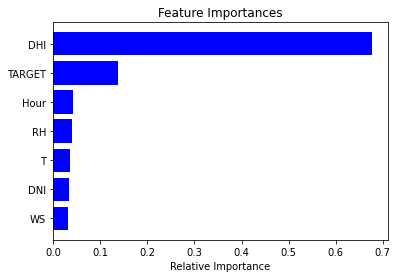

In [31]:
for name, importance in zip(features, RF.feature_importances_):
    print(name, "=", importance)

#features = ['DHI', 'DNI', 'WS', 'RH', 'T']
importances = RF.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

예상대로 DHI가 매우 중요합니다. 사실상 RH(습도), WS(풍속), T(기온)은 중요하지 않게 나왔습니다. 기온은 시각화 상으로는 높은 상관성을 보일 것으로 예상했으나, DHI와 다중공선성을 띄기 때문에 이런 결과가 나오지 않았을까 추측해봅니다.

In [34]:
%%time
cat = CatBoostRegressor(random_state=42)
cat.fit(X_train_original, y_train_original)
pred = cat.predict(X_test_original)

Learning rate set to 0.075261
0:	learn: 23.7169164	total: 5.78ms	remaining: 5.77s
1:	learn: 22.1057524	total: 10.8ms	remaining: 5.39s
2:	learn: 20.6061095	total: 15.8ms	remaining: 5.24s
3:	learn: 19.2499167	total: 20.8ms	remaining: 5.18s
4:	learn: 17.9517029	total: 25.6ms	remaining: 5.1s
5:	learn: 16.7531686	total: 31ms	remaining: 5.13s
6:	learn: 15.6368781	total: 35.8ms	remaining: 5.08s
7:	learn: 14.6009767	total: 40.7ms	remaining: 5.04s
8:	learn: 13.6513123	total: 45.8ms	remaining: 5.05s
9:	learn: 12.7720939	total: 50.8ms	remaining: 5.03s
10:	learn: 11.9731993	total: 56.1ms	remaining: 5.04s
11:	learn: 11.2099398	total: 61.7ms	remaining: 5.08s
12:	learn: 10.4963707	total: 67.3ms	remaining: 5.11s
13:	learn: 9.8424014	total: 72.3ms	remaining: 5.09s
14:	learn: 9.2855926	total: 77.4ms	remaining: 5.08s
15:	learn: 8.7208319	total: 82.4ms	remaining: 5.07s
16:	learn: 8.2048700	total: 89.4ms	remaining: 5.17s
17:	learn: 7.7178019	total: 95.3ms	remaining: 5.2s
18:	learn: 7.2847649	total: 100ms	r

In [35]:
mean_squared_error(pred, y_test_original, squared=False)

1.0831680627573659

In [36]:
%%time
cat = CatBoostRegressor(random_state=42)
cat.fit(X_train_shift, y_train_shift1)
pred = cat.predict(X_test_shift)

Learning rate set to 0.075261
0:	learn: 24.0166781	total: 6.71ms	remaining: 6.71s
1:	learn: 22.7141447	total: 11.8ms	remaining: 5.91s
2:	learn: 21.5230905	total: 17.3ms	remaining: 5.73s
3:	learn: 20.4144757	total: 22.2ms	remaining: 5.53s
4:	learn: 19.4022037	total: 27.3ms	remaining: 5.44s
5:	learn: 18.4975752	total: 32.4ms	remaining: 5.36s
6:	learn: 17.6793613	total: 37.5ms	remaining: 5.32s
7:	learn: 16.9570726	total: 42.5ms	remaining: 5.27s
8:	learn: 16.2967313	total: 48ms	remaining: 5.29s
9:	learn: 15.7015204	total: 53.1ms	remaining: 5.26s
10:	learn: 15.1610384	total: 58.9ms	remaining: 5.29s
11:	learn: 14.6659106	total: 64.5ms	remaining: 5.31s
12:	learn: 14.2151142	total: 69.7ms	remaining: 5.29s
13:	learn: 13.8245313	total: 75.1ms	remaining: 5.29s
14:	learn: 13.4723822	total: 80.6ms	remaining: 5.29s
15:	learn: 13.1699993	total: 86ms	remaining: 5.29s
16:	learn: 12.8940596	total: 91.5ms	remaining: 5.29s
17:	learn: 12.6536863	total: 97ms	remaining: 5.29s
18:	learn: 12.4206214	total: 103

In [37]:
mean_squared_error(pred, y_test_shift1, squared=False)

12.60497578238708

In [38]:
%%time
cat = CatBoostRegressor(random_state=42)
cat.fit(X_train_shift, y_train_shift2)
pred = cat.predict(X_test_shift)

Learning rate set to 0.075261
0:	learn: 24.0199088	total: 5.77ms	remaining: 5.77s
1:	learn: 22.7483216	total: 10.8ms	remaining: 5.37s
2:	learn: 21.5835073	total: 15.9ms	remaining: 5.3s
3:	learn: 20.5047412	total: 21ms	remaining: 5.22s
4:	learn: 19.5503737	total: 26ms	remaining: 5.17s
5:	learn: 18.6635043	total: 31.2ms	remaining: 5.17s
6:	learn: 17.8498196	total: 36.4ms	remaining: 5.16s
7:	learn: 17.1269971	total: 41.5ms	remaining: 5.14s
8:	learn: 16.4949599	total: 46.4ms	remaining: 5.11s
9:	learn: 15.9132052	total: 51.6ms	remaining: 5.11s
10:	learn: 15.3697702	total: 57.1ms	remaining: 5.14s
11:	learn: 14.9068566	total: 62.2ms	remaining: 5.12s
12:	learn: 14.4794554	total: 68.2ms	remaining: 5.17s
13:	learn: 14.0830009	total: 73.4ms	remaining: 5.17s
14:	learn: 13.7624980	total: 78.5ms	remaining: 5.15s
15:	learn: 13.4656105	total: 83.6ms	remaining: 5.14s
16:	learn: 13.1862198	total: 89.1ms	remaining: 5.15s
17:	learn: 12.9504857	total: 95.6ms	remaining: 5.21s
18:	learn: 12.7356926	total: 10

In [39]:
mean_squared_error(pred, y_test_shift2, squared=False)

12.945686209216838

Hour = 19.85345112855807
DHI = 24.354569073347612
DNI = 9.158280784023182
WS = 7.127415250576404
RH = 9.683370993221402
T = 13.393500148430357
TARGET = 16.429412621842967


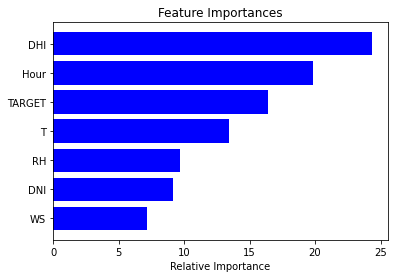

In [40]:
for name, importance in zip(features, cat.feature_importances_):
    print(name, "=", importance)

#features = ['DHI', 'DNI', 'WS', 'RH', 'T']
importances = cat.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

가장 높은 성능을 낸 CatBoost는 DNI와 DHI가 비슷한 수준으로 중요했스빈다. T도 나름 중요했고요.<br>
WS와 Min은 전혀 중요하지 않습니다. 사실 Hour와 RH도 그닥...

In [41]:
%%time
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_original, y_train_original)
pred = xgb.predict(X_test_original)

mean_squared_error(pred, y_test_original, squared=False)

Wall time: 943 ms


1.384952

In [42]:
%%time
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_shift, y_train_shift1)
pred = xgb.predict(X_test_shift)

mean_squared_error(pred, y_test_shift1, squared=False)

Wall time: 536 ms


12.848769

In [43]:
%%time
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_shift, y_train_shift2)
pred = xgb.predict(X_test_shift)

mean_squared_error(pred, y_test_shift2, squared=False)

Wall time: 536 ms


13.266887

In [44]:
%%time
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train_original, y_train_original)
pred = lgbm.predict(X_test_original)

mean_squared_error(pred, y_test_original, squared=False)

Wall time: 153 ms


1.2679868015070503

In [45]:
%%time
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train_shift, y_train_shift1)
pred = lgbm.predict(X_test_shift)

mean_squared_error(pred, y_test_shift1, squared=False)

Wall time: 154 ms


12.448821989747955

In [46]:
%%time
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train_shift, y_train_shift2)
pred = lgbm.predict(X_test_shift)

mean_squared_error(pred, y_test_shift2, squared=False)

Wall time: 149 ms


12.68228864567175

리니어 모델은 약 2배, 트리 기반 모델은 약 10배의 성능 차이를 냅니다.

진짜 애매하네요. 테스트 데이터만 있으면 예측력을 엄청 올릴 수 있는데, 예측의 예측은 또 성능이 좋지 않고...

근데 사실 그렇네요. 그 날 날씨를 알면 이 예측을 할 이유가 없지. 모르니까 이전 데이터로 예측을 하려는 것이지

In [240]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

In [235]:
%%time
quantiles = [0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def GBM(q):
    # (a) Modeling  
    mod = GradientBoostingRegressor(loss='quantile',
                                    alpha=q,
                                    n_estimators=500,
                                    max_depth=8,
                                    learning_rate=.01,
                                    min_samples_leaf=20,
                                    min_samples_split=20)
    mod.fit(X_train, y_train)

    # (b) Predictions
    pred = pd.Series(mod.predict(X_test).round(2))
    return pred, mod

GBM_models=[]
GBM_actual_pred = pd.DataFrame()

for q in quantiles:
    pred , model = GBM(q)
    GBM_models.append(model)
    GBM_actual_pred = pd.concat([GBM_actual_pred, pred], axis=1)
    
GBM_actual_pred.columns=quantiles
GBM_actual_pred['actual'] = y_test
GBM_actual_pred['interval'] = GBM_actual_pred[np.max(quantiles)] - GBM_actual_pred[np.min(quantiles)]
GBM_actual_pred = GBM_actual_pred.sort_values('interval')

In [325]:
r2 = metrics.r2_score(GBM_actual_pred['actual'], GBM_actual_pred[0.5]).round(4)
print('R2 score is {}'.format(r2) ) # 0.89
GBM_actual_pred

R2 score is 0.9952


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,actual,interval
10908,34.17,32.63,34.46,33.91,34.38,33.10,33.78,33.32,33.06,30.963333,-1.11
11674,37.04,37.50,37.95,36.79,35.72,37.67,35.60,35.88,36.04,35.001411,-1.00
4581,5.76,5.97,5.87,5.96,5.82,5.93,9.60,7.77,4.96,6.004878,-0.80
10909,28.87,27.92,28.62,28.28,27.28,28.31,26.56,26.07,28.14,25.521854,-0.73
10907,35.06,36.04,35.43,37.36,33.91,36.15,34.98,35.29,34.41,32.839897,-0.65
...,...,...,...,...,...,...,...,...,...,...,...
775,51.67,65.24,69.86,78.29,79.43,82.08,86.53,88.88,93.07,99.095734,41.40
1734,45.68,58.41,59.61,70.31,75.54,75.56,80.71,82.93,87.34,92.054649,41.66
2075,39.14,53.69,61.67,65.12,74.07,75.51,78.31,79.70,81.09,79.665466,41.95
1731,40.54,55.24,66.21,68.30,76.43,73.69,77.13,80.38,86.80,84.174149,46.26


## 4-2. 시계열 모델 구성: 실패다.

In [13]:
import numpy as np
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [14]:
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.080002,-12,0.0
1,0,0,30,0,0,1.5,69.059998,-12,0.0
2,0,1,0,0,0,1.6,71.779999,-12,0.0
3,0,1,30,0,0,1.6,71.750000,-12,0.0
4,0,2,0,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.699997,-4,0.0
52556,1094,22,0,0,0,2.4,66.790001,-4,0.0
52557,1094,22,30,0,0,2.2,66.779999,-4,0.0
52558,1094,23,0,0,0,2.1,67.720001,-4,0.0


In [285]:
DHI = train.DHI.values
DNI = train.DNI.values
WS = train.WS.values
RH = train.RH.values
TEMP = train['T'].values

In [287]:
DHI.shape, DNI.shape, WS.shape, RH.shape, TEMP.shape

((52560,), (52560,), (52560,), (52560,), (52560,))

In [288]:
# 차원을 맞춰줍니다.
DHI = tf.expand_dims(DHI[:], -1)
DNI = tf.expand_dims(DNI[:], -1)
WS = tf.expand_dims(WS[:], -1)
RH = tf.expand_dims(RH[:], -1)
TEMP = tf.expand_dims(TEMP[:], -1)

In [290]:
DHI.shape, DNI.shape, WS.shape, RH.shape, TEMP.shape

((52560, 1), (52560, 1), (52560, 1), (52560, 1), (52560, 1))

In [289]:
from sklearn.preprocessing import MinMaxScaler

# 스케일링을 해줘야...
scaler = MinMaxScaler(feature_range=(0, 1))

DHI = scaler.fit_transform(DHI)
DNI = scaler.fit_transform(DNI)
WS = scaler.fit_transform(WS)
RH = scaler.fit_transform(RH)
TEMP = scaler.fit_transform(TEMP)

In [291]:
# 데이터 분리
def data_split(data):
    train = data[:30000]
    val = data[30000:41000]
    test = data[41000:]
    
    return train, val, test

In [292]:
DHI_train, DHI_val, DHI_test = data_split(DHI)

In [293]:
#look_back에 맞춰서 데이터셋을 구성해주는 함수입니다.

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back)])
        dataY.append(signal_data[i + look_back])
    return np.array(dataX), np.array(dataY)

In [312]:
look_back = 336
# 48개 x 7일 = 336개로 다음 타겟을 맞춰야 합니다.
# 그렇게 96개를 추가로 예측하면 원하는 데이터를 구할 수 있습니다.

# 데이터셋 생성
# dhi_x_train, dhi_y_train = create_dataset(DHI_train, look_back)
# dhi_x_val, dhi_y_val = create_dataset(DHI_val, look_back)
# dhi_x_test, dhi_y_test = create_dataset(DHI_test, look_back)

dhi_x_train, dhi_y_train = create_dataset(DHI, look_back)
dni_x_train, dni_y_train = create_dataset(DNI, look_back)
ws_x_train, ws_y_train = create_dataset(WS, look_back)
rh_x_train, rh_y_train = create_dataset(RH, look_back)
temp_x_train, temp_y_train = create_dataset(TEMP, look_back)

In [313]:
dhi_x_train.shape, dhi_y_train.shape, temp_x_train.shape

((52224, 336, 1), (52224, 1), (52224, 336, 1))

In [314]:
# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

In [315]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

In [316]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (1, 336, 32)              4352      
_________________________________________________________________
dropout_21 (Dropout)         (1, 336, 32)              0         
_________________________________________________________________
lstm_22 (LSTM)               (1, 336, 32)              8320      
_________________________________________________________________
dropout_22 (Dropout)         (1, 336, 32)              0         
_________________________________________________________________
lstm_23 (LSTM)               (1, 32)                   8320      
_________________________________________________________________
dropout_23 (Dropout)         (1, 32)                   0         
_________________________________________________________________
dense_7 (Dense)              (1, 1)                   

In [299]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [300]:
# 4. 모델 학습시키기
# 2epoch 까지 loss가 확 줄고, 그 밑으로는 아주 미세하게 줄어듭니다. 그러니 효율적으로 2epoch만 돌립니다.
custom_hist = CustomHistory()
custom_hist.init()
with tf.device('/cpu:0'):
    for i in range(2):
        model.fit(dhi_x_train, dhi_y_train, epochs=1, batch_size=1, shuffle=False,
                  callbacks=[custom_hist], validation_data=(dhi_x_val, dhi_y_val))
        model.reset_states()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29664/29664 [==============================] - ETA: 0s - loss: 0.0123WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000029982ED99D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

In [304]:
# 6. 모델 평가하기
with tf.device('/cpu:0'):
    trainScore = model.evaluate(dhi_x_train, dhi_y_train, batch_size=1, verbose=0)
    model.reset_states()
    print('Train Score: ', trainScore)
    valScore = model.evaluate(dhi_x_val, dhi_y_val, batch_size=1, verbose=0)
    model.reset_states()
    print('Validataion Score: ', valScore)
    testScore = model.evaluate(dhi_x_test, dhi_y_test, batch_size=1, verbose=0)
    model.reset_states()
    print('Test Score: ', testScore)

Train Score:  0.01523176021873951
Validataion Score:  0.00626183208078146
Test Score:  0.0154753802344203


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


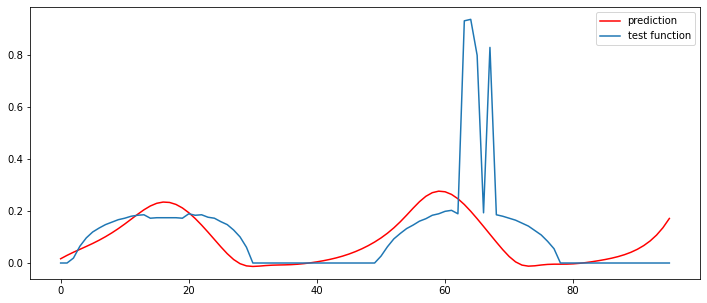

In [305]:
# 7. 모델 사용하기
with tf.device('/cpu:0'):
    look_ahead = 96 # 이틀치의 데이터를 출력하겠습니다.
    xhat = dhi_x_test[0]
    predictions = np.zeros((look_ahead,1))
    for i in range(look_ahead):
        prediction = model.predict(np.array([xhat]), batch_size=1)
        predictions[i] = prediction
        xhat = np.vstack([xhat[1:],prediction])

    plt.figure(figsize=(12,5))
    plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
    plt.plot(np.arange(look_ahead),dhi_y_test[:look_ahead],label="test function")
    plt.legend()
    plt.show()

In [306]:
# 예측 모델을 만듭시다.
def predictor(column):
    look_ahead = 95 # 이틀치의 데이터를 출력하겠습니다. 0~95
    predict_all = pd.DataFrame()

    with tf.device('/cpu:0'):
        for i in tqdm(range(81)): # 81개의 파일을 하나씩 불러와 예측을 시키고 어펜드하겠습니다.
            file_path = TEST_PATH + '/' + str(i) + '.csv' # 81 개의 path를 순서대로 불러옵니다.
            temp = pd.read_csv(file_path) # temp에 df를 넣어줍니다.

            xhat = temp[column] # 학습시킬 train 데이터입니다.
            xhat = tf.expand_dims(xhat, axis=-1) # 모델의 인풋 shape와 맞춰줍니다.

            #predictions = np.zeros((look_ahead, 1)) # 시각화용으로 없어도 됩니다.
            predict_stack = 0 # 기준을 잡아줍니다.
            
            for i in range(look_ahead): # 여기서 예측하겠습니다.
                prediction = model.predict(np.array([xhat]), batch_size=1) # xhat에 대해서 다음 데이터 포인트를 한개 예측합니다.
                predict_stack = np.vstack([predict_stack, prediction]) # 하나씩 쌓습니다.
                xhat = np.vstack([xhat[1:], prediction]) # 예측한 데이터를 xhat에 붙입니다. 그러면 다음 데이터를 예측할 train 데이터가 됩니다.

            predict_stack = pd.DataFrame(predict_stack) # stack을 df로 바꿔줍니다.
            predict_all = predict_all.append(predict_stack) # 각 파일의 stack을 전부 합쳐줍니다.
            
    predict_all.rename({0:column}, axis=1, inplace=True) # 이름이 없으니 이름을 정해줍니다.
    
    return predict_all

In [307]:
new_test_dhi = predictor('DHI')

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [06:03<00:00,  4.49s/it]


In [309]:
new_test_dhi.to_csv('./new_test_dhi_01.csv')

In [318]:
# 변수 집어 넣으면 자동으로 모델 학습하고, 예측하여 아웃풋 내는 반복 함수를 돌리겠습니다.
def lstm_feature_forecast(train, test, column):

    with tf.device('/cpu:0'):
        for i in range(2):
            model.fit(train, test, epochs=1, batch_size=1, shuffle=False)
            model.reset_states()
            
    # 여기부터 예측 파트
    look_ahead = 95 # 이틀치의 데이터를 출력하겠습니다. 0~95
    predict_all = pd.DataFrame()

    with tf.device('/cpu:0'):
        for i in tqdm(range(81)): # 81개의 파일을 하나씩 불러와 예측을 시키고 어펜드하겠습니다.
            file_path = TEST_PATH + '/' + str(i) + '.csv' # 81 개의 path를 순서대로 불러옵니다.
            temp = pd.read_csv(file_path) # temp에 df를 넣어줍니다.

            xhat = temp[column] # 학습시킬 train 데이터입니다.
            xhat = tf.expand_dims(xhat, axis=-1) # 모델의 인풋 shape와 맞춰줍니다.

            #predictions = np.zeros((look_ahead, 1)) # 시각화용으로 없어도 됩니다.
            predict_stack = 0 # 기준을 잡아줍니다.
            
            for i in range(look_ahead): # 여기서 예측하겠습니다.
                prediction = model.predict(np.array([xhat]), batch_size=1) # xhat에 대해서 다음 데이터 포인트를 한개 예측합니다.
                predict_stack = np.vstack([predict_stack, prediction]) # 하나씩 쌓습니다.
                xhat = np.vstack([xhat[1:], prediction]) # 예측한 데이터를 xhat에 붙입니다. 그러면 다음 데이터를 예측할 train 데이터가 됩니다.

            predict_stack = pd.DataFrame(predict_stack) # stack을 df로 바꿔줍니다.
            predict_all = predict_all.append(predict_stack) # 각 파일의 stack을 전부 합쳐줍니다.
            
    predict_all.rename({0:column}, axis=1, inplace=True) # 이름이 없으니 이름을 정해줍니다.
    
    return predict_all

In [ ]:
# dhi_x_train, dhi_y_train
# dni_x_train, dni_y_train
# ws_x_train, ws_y_train
# rh_x_train, rh_y_train
# temp_x_train, temp_y_train

In [319]:
new_test_dni = lstm_feature_forecast(dni_x_train, dni_y_train, 'DNI')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
52224/52224 [==============================] - 5147s 99ms/step - loss: 0.0195


  0%|                                                                                           | 0/81 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [06:06<00:00,  4.52s/it]


In [320]:
new_test_dni.to_csv('./new_test_dni_01.csv')

In [327]:
new_test_ws = lstm_feature_forecast(ws_x_train, ws_y_train, 'WS')
new_test_ws.to_csv('./new_test_ws_01.csv')

52224/52224 [==============================] - 5152s 99ms/step - loss: 5.6056e-04


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [06:09<00:00,  4.56s/it]


In [328]:
new_test_rh = lstm_feature_forecast(rh_x_train, rh_y_train, 'RH')
new_test_rh.to_csv('./new_test_rh_01.csv')

52224/52224 [==============================] - 5202s 100ms/step - loss: 0.0018


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [06:09<00:00,  4.56s/it]


In [335]:
new_test_temp = lstm_feature_forecast(temp_x_train, temp_y_train, 'TEMP')
new_test_temp.to_csv('./new_test_temp_01.csv')

52224/52224 [==============================] - 5231s 100ms/step - loss: 4.1061e-04


  0%|                                                                                           | 0/81 [00:00<?, ?it/s]


KeyError: 'TEMP'

In [ ]:
# 예측 모델을 만듭시다.
def predictor(column):
    look_ahead = 95 # 이틀치의 데이터를 출력하겠습니다. 0~95
    predict_all = pd.DataFrame()

    with tf.device('/cpu:0'):
        for i in tqdm(range(81)): # 81개의 파일을 하나씩 불러와 예측을 시키고 어펜드하겠습니다.
            file_path = TEST_PATH + '/' + str(i) + '.csv' # 81 개의 path를 순서대로 불러옵니다.
            temp = pd.read_csv(file_path) # temp에 df를 넣어줍니다.

            xhat = temp[column] # 학습시킬 train 데이터입니다.
            xhat = tf.expand_dims(xhat, axis=-1) # 모델의 인풋 shape와 맞춰줍니다.

            #predictions = np.zeros((look_ahead, 1)) # 시각화용으로 없어도 됩니다.
            predict_stack = 0 # 기준을 잡아줍니다.
            
            for i in range(look_ahead): # 여기서 예측하겠습니다.
                prediction = model.predict(np.array([xhat]), batch_size=1) # xhat에 대해서 다음 데이터 포인트를 한개 예측합니다.
                predict_stack = np.vstack([predict_stack, prediction]) # 하나씩 쌓습니다.
                xhat = np.vstack([xhat[1:], prediction]) # 예측한 데이터를 xhat에 붙입니다. 그러면 다음 데이터를 예측할 train 데이터가 됩니다.

            predict_stack = pd.DataFrame(predict_stack) # stack을 df로 바꿔줍니다.
            predict_all = predict_all.append(predict_stack) # 각 파일의 stack을 전부 합쳐줍니다.
            
    predict_all.rename({0:column}, axis=1, inplace=True) # 이름이 없으니 이름을 정해줍니다.
    
    return predict_all

In [353]:
new_test_temp = predictor('T')

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [06:15<00:00,  4.64s/it]


In [354]:
new_test = pd.concat([new_test_dhi, new_test_dni, new_test_ws, new_test_rh, new_test_temp], axis=1)

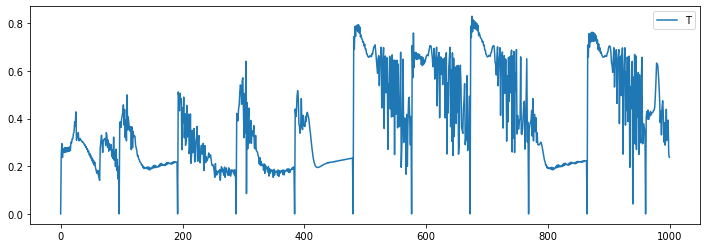

In [366]:
new_test_temp.reset_index(drop=True)[:1000].plot(figsize=(12,4))
plt.show()

In [355]:
new_test

,DHI,DNI,WS,RH,T
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.009903,0.022140,1.420249,1.438798,0.248215
2,-0.012200,0.019306,1.136514,1.273764,0.295203
3,-0.012765,0.013023,1.387881,1.170595,0.236951
4,-0.012902,0.011301,1.107281,1.193467,0.266028
...,...,...,...,...,...
91,0.123505,0.085515,0.061479,0.530051,0.388514
92,0.119175,0.085565,0.061513,0.530084,0.229902
93,0.113221,0.085560,0.061518,0.530118,0.264695
94,0.105706,0.085503,0.061518,0.530152,0.351880


In [356]:
new_test['Hour'] = X_test.reset_index()['Hour'][:7776]
new_test

,DHI,DNI,WS,RH,T,Hour
0,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,-0.009903,0.022140,1.420249,1.438798,0.248215,0
2,-0.012200,0.019306,1.136514,1.273764,0.295203,1
3,-0.012765,0.013023,1.387881,1.170595,0.236951,1
4,-0.012902,0.011301,1.107281,1.193467,0.266028,2
...,...,...,...,...,...,...
91,0.123505,0.085515,0.061479,0.530051,0.388514,21
92,0.119175,0.085565,0.061513,0.530084,0.229902,22
93,0.113221,0.085560,0.061518,0.530118,0.264695,22
94,0.105706,0.085503,0.061518,0.530152,0.351880,23


In [377]:
new_train = train[['DHI', 'DNI','WS' ,'RH', 'Hour','T', 'TARGET']]

In [378]:
new_X_train = new_train[['DHI', 'DNI', 'WS', 'RH','T', 'Hour']]
new_y_train = new_train['TARGET']

In [379]:
new_X_train.shape, new_y_train.shape

((52560, 6), (52560,))

In [381]:
new_X_train.isnull().sum()

DHI     0
DNI     0
WS      0
RH      0
T       0
Hour    0
dtype: int64

In [380]:
new_test.isnull().sum()

DHI     0
DNI     0
WS      0
RH      0
T       0
Hour    0
dtype: int64

In [382]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [383]:
# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [384]:
# Target 예측

def train_data(X_train, Y_train, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [385]:
# Target1
models_1, results_1 = train_data(new_X_train, new_y_train, new_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
0.9
[LightGBM] [Warning] bagging

In [386]:
results_1

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,-0.02,0.00,0.42,0.35,0.00,0.00
2,0.00,0.00,0.00,-0.02,0.00,0.42,0.35,0.00,0.00
3,0.00,0.00,0.00,-0.02,0.00,0.42,0.35,0.00,0.00
4,0.00,0.00,0.00,-0.02,0.00,0.42,0.35,0.00,0.00
...,...,...,...,...,...,...,...,...,...
7771,-0.29,0.93,0.44,0.55,0.88,1.16,0.91,0.37,0.36
7772,-0.29,0.93,0.44,0.55,0.88,1.16,0.91,0.37,0.36
7773,-0.29,0.93,0.44,0.55,0.88,1.16,0.91,0.37,0.36
7774,-0.29,0.93,0.44,0.55,0.88,1.16,0.91,0.37,0.36


In [387]:
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.05
1,0.csv_Day7_0h30m,0.0,0.00,0.00,-0.02,0.00,0.27,0.41,0.00,2.05
2,0.csv_Day7_1h00m,0.0,0.00,0.00,-0.02,0.00,0.27,0.41,0.00,2.05
3,0.csv_Day7_1h30m,0.0,0.00,0.00,-0.02,0.00,0.27,0.41,0.00,2.05
4,0.csv_Day7_2h00m,0.0,0.00,0.00,-0.02,0.00,0.27,0.41,0.00,2.05
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.9,0.52,0.44,0.55,0.88,0.54,0.71,0.14,1.70
7772,80.csv_Day8_22h00m,0.9,0.52,0.44,0.55,0.88,0.54,0.71,0.14,1.70
7773,80.csv_Day8_22h30m,0.9,0.52,0.44,0.55,0.88,0.54,0.71,0.14,1.70
7774,80.csv_Day8_23h00m,0.9,0.52,0.44,0.55,0.88,0.54,0.71,0.14,1.70


In [388]:
submission.loc[:, "q_0.1":] = results_1.sort_index().values

In [389]:
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,-0.02,0.00,0.42,0.35,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,-0.02,0.00,0.42,0.35,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,-0.02,0.00,0.42,0.35,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,-0.02,0.00,0.42,0.35,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,-0.29,0.93,0.44,0.55,0.88,1.16,0.91,0.37,0.36
7772,80.csv_Day8_22h00m,-0.29,0.93,0.44,0.55,0.88,1.16,0.91,0.37,0.36
7773,80.csv_Day8_22h30m,-0.29,0.93,0.44,0.55,0.88,1.16,0.91,0.37,0.36
7774,80.csv_Day8_23h00m,-0.29,0.93,0.44,0.55,0.88,1.16,0.91,0.37,0.36


In [390]:
submission.to_csv('./submission/submission_model_test_201230_2.csv', index=False)

# 000. 창고

In [358]:
# Loss Function
# Pinball Loss
quantile = [0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9]

def pinball_loss(y_true, y_pred, quantile):
    # y_true : numpy array
    # y_pred : 
    # quantile : range
    loss = 0
    for quan, tau in zip(quantile, range(len(quantile))):
        for tau2 in range(len(quantile)):
            loss = max(quan * (y_true[tau][tau2] - y_pred), (quan - 1) * (y_true[tau][tau2] - y_pred))
            loss += loss
            
    return loss

In [352]:
y_pred = GBM_actual_pred[:5]
y_pred_numpy = y_pred.to_numpy()

In [355]:
y_pred

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,actual,interval
10908,34.17,32.63,34.46,33.91,34.38,33.10,33.78,33.32,33.06,30.963333,-1.11
11674,37.04,37.50,37.95,36.79,35.72,37.67,35.60,35.88,36.04,35.001411,-1.00
4581,5.76,5.97,5.87,5.96,5.82,5.93,9.60,7.77,4.96,6.004878,-0.80
10909,28.87,27.92,28.62,28.28,27.28,28.31,26.56,26.07,28.14,25.521854,-0.73
10907,35.06,36.04,35.43,37.36,33.91,36.15,34.98,35.29,34.41,32.839897,-0.65


In [353]:
y_pred_numpy

array([[34.17      , 32.63      , 34.46      , 33.91      , 34.38      ,
        33.1       , 33.78      , 33.32      , 33.06      , 30.96333313,
        -1.11      ],
       [37.04      , 37.5       , 37.95      , 36.79      , 35.72      ,
        37.67      , 35.6       , 35.88      , 36.04      , 35.00141144,
        -1.        ],
       [ 5.76      ,  5.97      ,  5.87      ,  5.96      ,  5.82      ,
         5.93      ,  9.6       ,  7.77      ,  4.96      ,  6.00487804,
        -0.8       ],
       [28.87      , 27.92      , 28.62      , 28.28      , 27.28      ,
        28.31      , 26.56      , 26.07      , 28.14      , 25.5218544 ,
        -0.73      ],
       [35.06      , 36.04      , 35.43      , 37.36      , 33.91      ,
        36.15      , 34.98      , 35.29      , 34.41      , 32.83989716,
        -0.65      ]])

In [331]:
y_true = 0.9
y_pred = 0.7
quan = 0.9
max(quan * (y_true - y_pred), (quan - 1) * (y_true - y_pred))

0.18000000000000008

In [363]:
y_true = y_pred_numpy

In [364]:
loss = 0
for quan, tau in zip(quantile, range(len(quantile))):
    print(quan)
    print(tau)
    for tau2 in range(len(quantile)):
        print(tau2)
        loss = max(quan * (y_true[tau][tau2] - y_pred), (quan - 1) * (y_true[tau][tau2] - y_pred))
        loss += loss

0.1
0
0


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [359]:
pinball_loss(y_pred_numpy, y_pred['actual'].to_numpy(), quantile)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()